*Date:* April 2025

*Author:* Marco Mongi

This notebook is the Capstone Project for the 5-Day Gen AI Intensive Course, by Google and Kaggle.

# Use case: Interactive Adventure Generator
The main goal of the project is to **entertain the user**. 

This is achieved by creating an **interactive adventure generator**, where a Large Language Model (LLM) creates a story and in certain points lets the player choose what to do next. What the player decides affects the progression of the story, as it is dinamically generated by the LLM based on the player's choices, which determines if the ending is good, bad or neutral.

**Generative AI is well suited to achieve this goal, as it has unlimited creative potential**, and can create infinite stories to entertain the user. 

In order to provide a better user experience, a **user interface** made with Gradio allows to interact easily with the LLM and configure some settings. Also, for a more natural interaction, bidirectional **voice interaction** was implemented.

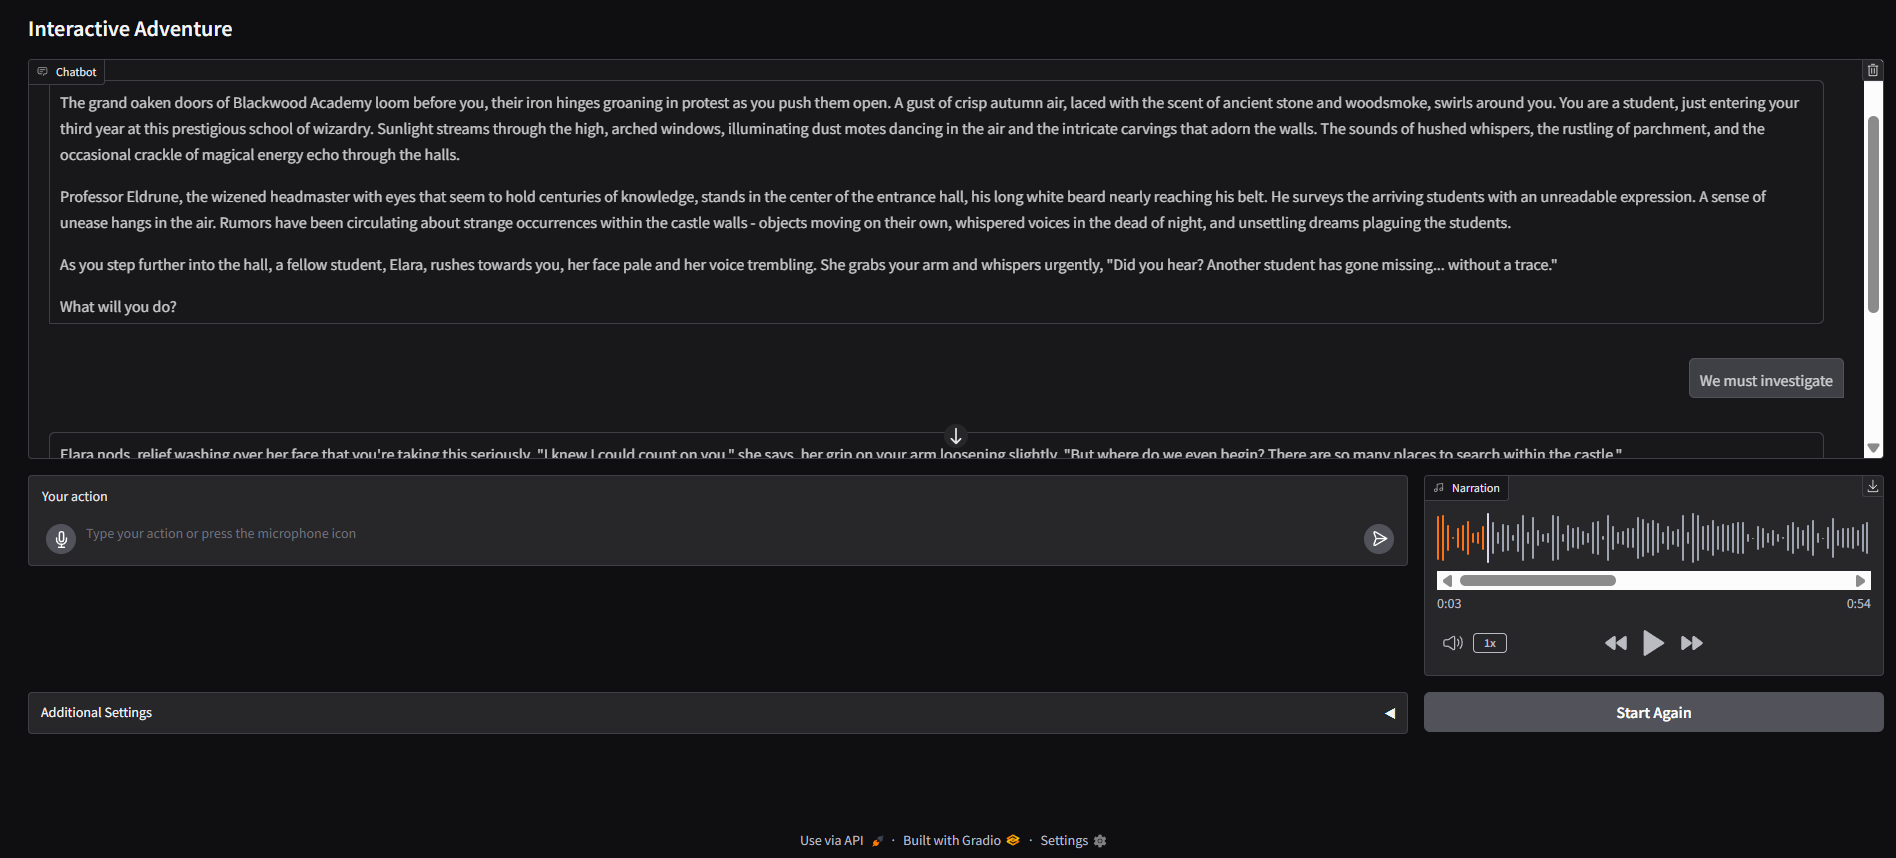

# Implementation overview
* **Model:** Gemini 2.0 flash is used because of it's fast-response capabilities and long context window
* **Prompt:** a system prompt is defined to control how the LLM behaves. The user can modify this prompt by specifying the language (there is a variable containing the language which is injected to the prompt) and custom instructions that modify the story's setting according to user's preferences.
* **Agentic Flow:** LangChain was used to define a flow where the narrator (LLM) and the player (user) nodes interact. Conditional edges are defined to end the story, either from the user node (when the user types "exit") or the narrator node (the story ends, and the string "The End." is detected).
* **Text to Speech:** Piper is used to convert the narrator's text to speech, as it is lightweight and natural sounding. Source: https://github.com/rhasspy/piper
* **Speech to Text:** The chosen Gemini model is multimodal, so it can accept audio input, but for this application it is preferred to process audio locally and send the transcribed text to Gemini. OpenAI's Whisper model is used to convert the user's voice to text. The small model's variant is used, as it is faster to run and provides good results. Source: https://github.com/openai/whisper
* **Languages:** english and spanish languages are supported, in text interaction, speech recognition and spoken language
* **Temperature control:** the user can modify the LLM's temperature setting with a slider in the user interface
* **User Interface:** The user can interact with the LLM using a familiar chatbot interface, using text or voice. Similarly, the narrator's output can be read or listened (automatic playback can be enabled). The user can also select the language, modify the LLM's temperature, add custom instructions or start a new story, everything from the User Interface.

# List of gen AI Capabilities used in this project

The following table lists all the Generative AI capabilities that this project makes use of, with a brief description of the way it is implemented in the project

| Capability          | How is implemented                                                                                                                                                                                     |
|---------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Few-shot prompting  | The prompt includes several example scenarios (Example 1–3) that guide the model’s behavior when generating the narrative.                                                                             |
| Audio understanding | User speech is captured via the multimodal textbox and then transcribed into text using Whisper, enabling seamless speech-to-text interaction.                                                         |
| Long context window | The system passes the entire conversation history to the LLM on each turn, allowing the model to maintain context throughout a multi-turn interaction.                                                 |
| Agents              | The conversation flow is structured using a simple agent model (with distinct “player” and “narrator” nodes and conditional transitions) that directs how the dialogue progresses based on user input. |
| Context caching     | Conversation history is stored in a session state variable, effectively caching context within each independent story session for coherent multi-turn interactions.                                    |

>Note: Some structured output/controlled generation is performed via prompt engineering, such as controlling the temperature value, the language used by the LLM and custom user instructions (by injecting variables in the prompt), the tone and narrative of the story, and ending it with the precise words "The End.", but as it a very simple output control, it is not listed in the table above

# Implementation (code)

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Install dependencies
The required packages that are not installed by default in the environment need to be installed manually

>Note: langchain-google-genai has a dependency problem with async-timeout and shows an error, but this does not affect the code

In [2]:
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' --retries 3
!pip install -q openai-whisper
!pip install -q --upgrade gradio piper-tts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 13.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8

## Import Google API Key
As the models runs on Google remote servers, in order to access them you must authenticate by providing an API Key.

Before running the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

This [documentation](https://ai.google.dev/gemini-api/docs/api-key) provides detailed instructions on how to generate your own API Key (if you don't already have one).

Once you have your Key, go to "Add-ons" on the top of the Kaggle Notebook interface and go to "Secrets". There you press the "Add Secret" button. In LABEL, write GOOGLE_API_KEY (this name should not be changed), and in VALUE paste your API Key

>Note: API Keys are for personal use, and should not be shared

In [3]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## Chatbot configuration
Defines initial prompts, examples, and generates the first message using the LLM.

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import SystemMessage, HumanMessage, AIMessage

In [5]:
# Initial settings
TEMPERATURE = 1                # Float between 0-2
LANGUAGE = "English"           # Available "English" and "Español"

# System Prompt
NARRATOR_SYS_MSG = (
    "system",
    "You are the narrator of an interactive story where the player's choices directly influence the progression and outcome of the narrative. "
    "Begin with an engaging introduction: set the stage with vivid, sensory details; describe the setting, introduce key characters, and hint at the main conflict. "
    "Speak directly to the player using 'you' to draw them into the story. As the story unfolds, organically introduce decision points where you ask the player what will he do. "
    "Reflect the consequences of the player's choices, leading to multiple possible endings. "
    "If the narrative reaches a point where the character dies, end with 'The End.' If the story concludes naturally, finish with 'The End.'"
)

# First message prompt: story generation guidelines
INTRO_STORY_PROMPT = (
    "Generate a welcome message for the interactive story with a new setting, introducing the player's role, environment, "
    "key characters, and hinting at the main conflict. End with a question asking what the player will do. Do not present possible alternatives, let the player create his own."
)
LANGUAGE_PROMPT = f"Answer always using the language {LANGUAGE}"
EXAMPLE1 = ("Example 1: You are a warrior in a medieval town, your sister recently died at the hands of an evil sorcerer. "
            "You are currently heading to the market to complete an errand for a friend, where you find a stranger sitting on a table and mysteriously looking at you. What will you do?")
EXAMPLE2 = ("Example 2: You are a pirate in Blackbeard's ship. The morning was going as usual, with the salty odor and calm waters, "
            "until you hear a stomp and see a giant tentacle going into the water. You ask another tripulant but he didn't hear or see anything. What will you do?")
EXAMPLE3 = ("Example 3: You are a spaceship captain in the hunt for the infamous thief Lauren DeHugh, your crew follows you with pride and loyalty, "
            "but recently the moods have been weird, you suspect that the new passenger may have something to do, but it could also be nothing. "
            "Currently, you need to check the map and then you have a few minutes of spare time. What do you want to do?")

DYNAMIC_PROMPT = INTRO_STORY_PROMPT + EXAMPLE1 + EXAMPLE2 + EXAMPLE3 + LANGUAGE_PROMPT


# Instantiate the initial LLM and generate the first message
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=TEMPERATURE)
first_message = llm.invoke([
    SystemMessage(content=NARRATOR_SYS_MSG[1]),
    HumanMessage(content=DYNAMIC_PROMPT)
]).content
initial_chat_history = [("", first_message)]

## Piper TTS Configuration
Configures the Piper voices, forcing redownload if needed.

In [6]:
from pathlib import Path
import tempfile
from piper.voice import PiperVoice
from piper.download import get_voices, ensure_voice_exists, find_voice
import numpy as np

In [7]:
download_dir = Path.home() / ".local/share/piper-tts/piper-voices"

voices_info = get_voices(download_dir)
piper_voice_names = {
    "Español": "es_ES-carlfm-x_low",
    "English": "en_US-joe-medium"
}
# Force redownload of corrupted configurations
for voice_name in piper_voice_names.values():
    config_file = download_dir / f"{voice_name}.onnx.json"
    if config_file.exists():
        config_file.unlink()
voices = {}
for lang, voice_name in piper_voice_names.items():
    ensure_voice_exists(voice_name, [download_dir], download_dir, voices_info)
    model_path, config_path = find_voice(voice_name, [download_dir])
    voices[lang] = PiperVoice.load(model_path, config_path=config_path)

def text_to_speech(lang: str, text: str) -> str:
    """Convert text to speech using Piper TTS and return a file path."""
    voice = voices[lang]
    raw_chunks = voice.synthesize_stream_raw(text)
    audio_bytes = b"".join(raw_chunks)
    audio_array = np.frombuffer(audio_bytes, dtype=np.int16)
    temp_audio = tempfile.NamedTemporaryFile(suffix=".wav", delete=False)
    sf.write(temp_audio.name, audio_array, voice.config.sample_rate, subtype="PCM_16")
    return temp_audio.name

## Whisper speech-to-text Configuration
Sets up the Whisper model for transcribing audio input.

In [8]:
import whisper

In [9]:
model_whisper = whisper.load_model("small")
language_codes = {
    "Español": "es",
    "English": "en"
}
def transcribe_audio(lang: str, audio_path: str) -> str:
    """Transcribe audio input using Whisper."""
    code = language_codes[lang]
    result = model_whisper.transcribe(audio_path, language=code)
    return result["text"].strip()

100%|███████████████████████████████████████| 461M/461M [00:13<00:00, 36.4MiB/s]


## Integrated Chatbot Generation (Streaming)
Processes multimodal input, streams the LLM response, and generates narration audio.

In [10]:
import gradio as gr

In [11]:
def integrated_generate(user_input, selected_language, autoplay_enabled, temperature_value, chat_history):
    """
    Process multimodal user input (text or microphone recording) and stream the LLM-generated narrative.
    Returns updated chat history and updated audio component.
    """
    input_text = ""
    recorded_audio = None
    if isinstance(user_input, dict):
        input_text = user_input.get("text", "").strip()
        files = user_input.get("files", [])
        if files:
            file_item = files[0]
            recorded_audio = file_item.get("path", None) if isinstance(file_item, dict) else file_item
    else:
        input_text = str(user_input).strip()
    
    final_input = input_text if input_text != "" else (transcribe_audio(selected_language, recorded_audio) if recorded_audio else "")
    
    if final_input == "":
        yield chat_history, chat_history, gr.update(interactive=True, value=""), None
        return
    if final_input.lower() in {"q", "quit", "exit", "goodbye"}:
        chat_history = chat_history + [(final_input, "The End.")]
        yield chat_history, chat_history, gr.update(interactive=False, value=""), None
        return

    # Build messages for LLM
    messages = [SystemMessage(content=NARRATOR_SYS_MSG[1])]
    if chat_history and chat_history[0][0] == "":
        messages.append(AIMessage(content=chat_history[0][1]))
    else:
        for human_msg, ai_msg in chat_history:
            messages.append(HumanMessage(content=human_msg))
            messages.append(AIMessage(content=ai_msg))
    messages.append(HumanMessage(content=final_input))
    chat_history = chat_history + [(final_input, "")]
    generated_text = ""
    streaming_llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", streaming=True, temperature=temperature_value)
    for token in streaming_llm.stream(messages):
        generated_text += token.content
        chat_history[-1] = (final_input, generated_text)
        yield chat_history, chat_history, gr.update(interactive=True, value=""), None
    end_condition = "The End." in generated_text
    narration_audio = text_to_speech(selected_language, generated_text)
    yield chat_history, chat_history, gr.update(interactive=not end_condition, value=""), gr.update(autoplay=autoplay_enabled, value=narration_audio)

## Reset chat function
Resets the conversation with updated settings (language, temperature, autoplay, and user preferences).

In [12]:
def reset_chat(selected_language, autoplay_enabled, temperature_value, user_preferences):
    """
    Reset the conversation using new settings and optional user preferences.
    Updates the global LANGUAGE and prompt variables accordingly.
    """
    global LANGUAGE, LANGUAGE_PROMPT, DYNAMIC_PROMPT
    LANGUAGE = selected_language
    LANGUAGE_PROMPT = f"Answer always using the language {LANGUAGE}"
    prefs_text = f"The story should take into consideration the following: {user_preferences.strip()}" if user_preferences.strip() else ""
    DYNAMIC_PROMPT = INTRO_STORY_PROMPT + EXAMPLE1 + EXAMPLE2 + EXAMPLE3 + LANGUAGE_PROMPT + prefs_text
    llm_instance = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=temperature_value)
    new_message = llm_instance.invoke([
        SystemMessage(content=NARRATOR_SYS_MSG[1]),
        HumanMessage(content=DYNAMIC_PROMPT)
    ]).content
    new_history = [("", new_message)]
    initial_audio = text_to_speech(selected_language, new_message)
    return new_history, new_history, gr.update(interactive=True, value=""), gr.update(autoplay=autoplay_enabled, value=initial_audio)

## Gradio User Interface
Organized into a full-width chat area on top and a two-row, two-column layout below for input, narration audio, additional settings, and a reset button.

In [13]:
import soundfile as sf

In [14]:
initial_audio = text_to_speech("English", first_message)

with gr.Blocks() as demo:
    # Upper section: Chat (full width)
    gr.Markdown("## Interactive Adventure")
    chat_box = gr.Chatbot(value=initial_chat_history, type="tuples")
    chat_state = gr.State(initial_chat_history)
    
    # Lower section: Two rows (first row: 75% user input, 25% narration audio; second row: 75% settings, 25% reset button)
    # Row 1: user input and narrator audio
    with gr.Row():
        with gr.Column(scale=3):
            user_input = gr.MultimodalTextbox(
                label="Your action",
                placeholder="Type your action or press the microphone icon",
                sources=["microphone"]
            )
        with gr.Column(scale=1):
            narration_audio = gr.Audio(value=initial_audio, label="Narration", type="filepath", autoplay=False)
    
    # Row 2: settings and reset button
    with gr.Row():
        with gr.Column(scale=3):
            with gr.Accordion("Additional Settings", open=False):
                setting_language = gr.Dropdown(
                    choices=["Español", "English"],
                    value="English",
                    label="Language"
                )
                setting_autoplay = gr.Checkbox(
                    value=False,
                    label="Autoplay Narration"
                )
                setting_temperature = gr.Slider(
                    minimum=0,
                    maximum=2,
                    step=0.1,
                    value=1,
                    label="Temperature"
                )
                setting_preferences = gr.Textbox(
                    label="User Preferences",
                    placeholder="Write your own guidelines to the story",
                    lines=2
                )
        with gr.Column(scale=1):
            reset_button = gr.Button("Start Again")
    
    # Trigger submission on Enter in MultimodalTextbox
    user_input.submit(
        fn=integrated_generate,
        inputs=[user_input, setting_language, setting_autoplay, setting_temperature, chat_state],
        outputs=[chat_box, chat_state, user_input, narration_audio]
    )
    
    reset_button.click(
        fn=reset_chat,
        inputs=[setting_language, setting_autoplay, setting_temperature, setting_preferences],
        outputs=[chat_box, chat_state, user_input, narration_audio],
        queue=False
    )
    
    #demo.launch(share=True, debug=True)


**IMPORTANT**

To run the app, you must **uncomment the following line**. 

>Note: It is recommended to access the app by the provided public URL, as microphone input is not allowed inside the Kaggle Notebook

In [15]:
#demo.launch(share=True)

# Citation
Addison Howard, Brenda Flynn, Kinjal Parekh, Myles O'Neill, Nate, and Polong Lin. Gen AI Intensive Course Capstone 2025Q1. https://kaggle.com/competitions/gen-ai-intensive-course-capstone-2025q1, 2025. Kaggle.